In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
## 大纲
##  1、载入数据
##   1.1、数据处理，载入类别数据,并转化为类别词表
##   1.2、数据处理，载入词表数据，为构建词表
##   1.3、载入，训练，验证，测试数据，并根据词表转词ID

##  2、 把数据转成tensor dataset
##  3、构建模型 buildmodel
##  4、训练模型
##  5、评测模型

In [3]:
dir_train='data\\cnews.train.txt'
dir_val='data\\cnews.val.txt'
dir_test='data\\cnews.test.txt'

# prepare data output files
seg_train_file = 'data\\cnews.train.seg.txt'
seg_val_file = 'data\\cnews.val.seg.txt'
seg_test_file = 'data\\cnews.test.seg.txt'

vocab_file = 'data\\cnews.vocab.txt'
# vocab_file = 'data\\cnews.vocab_simple.txt'
label_vocab_file = 'data\\cnews.label.vocab.txt'


def load_data(path,num_lines):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        example_pairs = [ [w for w in line.strip('\r\n').split('\t')] for line in lines[:num_lines]]
    return zip(*example_pairs)

def load_label_dict(path):
    labels,values=load_data(path,None)
    dd={}
    for index,label in enumerate(labels):
        if label not in dd.keys():
            dd[label]=index
    return dd

num_word_threshold = 10  ## 低于此频次的，忽略不纳入词表中来
def load_content_dict(path):
    labels,frequencys=load_data(path,None)
    dd={}
    for index,label in enumerate(labels):
        if int(frequencys[index]) < num_word_threshold:
            continue ## 去除低频词
#         if str(label) in ['，','。','！','？','、','：','；','“','\”','‘','’','《','》']:
#             continue ## 去除无效标点符号
        idx=len(dd)
        dd[label]=idx
    return dd


In [4]:
label_dict=load_label_dict(label_vocab_file)
print('label_dict:',label_dict)
word_dict=load_content_dict(vocab_file)
print('word dict length:',len(word_dict))
for index,(label,content) in enumerate(word_dict.items()):
    print(label,content)
    if index==3:
        break

label_dict: {'体育': 0, '娱乐': 1, '家居': 2, '房产': 3, '教育': 4, '时尚': 5, '时政': 6, '游戏': 7, '科技': 8, '财经': 9}
word dict length: 77331
<UNK> 0
， 1
的 2
。 3


In [5]:
# 加载数据并转化成 词ID
max_length=500 ## 控制等长的句子
    
def load_label_dict(path,num_lines):
    labels=[]
    features=[]
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines[:num_lines]:
            label, content = line.strip('\r\n').split('\t')
            labels.append(label_dict[label])
            features.append([word_dict_fun(word) for word in content.split()])
    return labels,features

def word_dict_fun(word):
    if word in word_dict.keys():
        return word_dict[word]
    else:
        return word_dict['<UNK>']
    
def load_data_dict(path,num_lines):
    labels=[]
    features=[]
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines[:num_lines]:
            label, content = line.strip('\r\n').split('\t')
            labels.append(label_dict[label])
            index=0
            sentence=[]
            for word in content.split():
#                 if str(word) in ['，','。','！','？','、','：','；','“','\”','‘','’','《','》']:
#                     continue ## 去除无效标点符号
                    
                if index<max_length:
                    sentence.append(word_dict_fun(word))
                else:
                    break
                index +=1
               
            if len(sentence)<max_length:
                less_num=max_length-len(sentence)
                [sentence.append(word_dict['<UNK>']) for _ in range(less_num)]    
            features.append(sentence)
    return labels,features

test_y,text_X=load_data_dict(seg_val_file,2)
print(test_y)
print(text_X[0],len(text_X[0]))
print('-------')
print(text_X[1],len(text_X[1]))
                

[0, 0]
[2315, 5736, 822, 1305, 11, 847, 20548, 3957, 1886, 1609, 14196, 6319, 156, 708, 82, 78, 103, 23, 941, 44, 1, 1075, 2317, 5955, 1925, 822, 952, 3568, 10847, 2315, 1, 670, 2, 124, 21, 1, 700, 12242, 72, 33, 72, 4675, 1, 252, 1551, 124, 131, 7349, 277, 285, 20, 118, 208, 1, 4233, 700, 12, 385, 6, 1305, 1406, 11, 1512, 11, 5354, 5, 847, 5, 5653, 5, 1609, 5, 2937, 17196, 11, 1886, 5, 23450, 27064, 5, 2026, 6186, 5, 5954, 141, 5, 13010, 1012, 156, 1075, 1144, 1647, 986, 1012, 156, 1075, 822, 0, 1647, 986, 1012, 156, 1075, 4155, 986, 1012, 2315, 5736, 822, 7740, 12595, 986, 17, 156, 1499, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [6]:
y_train,x_train=load_data_dict(seg_train_file,None)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
print('加载训练数据集完成：',len(y_train))

y_val,x_val=load_data_dict(seg_val_file,None)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
print('加载验证数据集完成：',len(y_val))

y_test,x_test=load_data_dict(seg_test_file,None)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
print('加载测试数据集完成：',len(y_test))

加载训练数据集完成： 50000
加载验证数据集完成： 5000
加载测试数据集完成： 10000


In [7]:
# 装换tensor dataset
buffer_size=len(y_train)
batch_size=64


train_dataset = train_dataset.shuffle(50000).batch(batch_size)
# train_dataset = train_dataset.batch(batch_size)
print('转换处理训练数据集完成')

val_dataset = val_dataset.shuffle(5000).batch(batch_size)
# val_dataset = val_dataset.batch(batch_size)
print('转换处理验证数据集完成')

test_dataset = test_dataset.shuffle(10000).batch(batch_size)
# test_dataset = test_dataset.batch(batch_size)
# print('转换处理测试数据集完成')
    

转换处理训练数据集完成
转换处理验证数据集完成


In [8]:
for x, y in train_dataset.take(1):
    print(x, y)
    
for x, y in val_dataset.take(1):
    print(x, y)

tf.Tensor(
[[11086   312  2109 ...     0     0     0]
 [ 6118    11   945 ...     0     0     0]
 [ 2371 13005 15301 ... 21446    19   104]
 ...
 [ 1540  1019 55119 ...     0     0     0]
 [22113    11   224 ...     0     0     0]
 [  788    27  9191 ...  2727   936     1]], shape=(64, 500), dtype=int32) tf.Tensor(
[2 1 0 8 6 7 5 4 8 2 0 0 6 1 4 9 8 5 4 4 2 5 5 3 7 5 4 6 4 0 0 5 8 9 0 3 0
 4 9 0 4 9 4 4 8 4 6 2 2 0 3 1 3 3 5 1 2 0 0 3 6 3 4 4], shape=(64,), dtype=int32)
tf.Tensor(
[[ 4071 26255    15 ...  9806     3   280]
 [  467    11  3814 ...     7  9951   371]
 [ 2026  2642     0 ...   667    32  1026]
 ...
 [    0 11191  6764 ...     0     0     0]
 [ 3214  8626  8896 ...    53   402  1325]
 [   15 12925    14 ...   199 20821     4]], shape=(64, 500), dtype=int32) tf.Tensor(
[1 5 0 2 1 6 3 5 8 1 1 3 8 3 6 3 2 5 9 1 8 0 7 7 9 6 7 8 6 5 0 5 5 0 8 4 4
 8 4 1 0 9 6 1 0 1 8 3 8 1 8 6 6 0 1 3 0 7 8 5 4 3 6 1], shape=(64,), dtype=int32)


In [9]:
embedding_dim = 16  ## 词语对应向量的长度
# batch_size = 64
vocab_size = len(word_dict)
print(vocab_size)


## 双向单层的LSTM
bi_lstm_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=32, return_sequences=False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(10, activation='softmax'),
])



bi_lstm_model.summary()
bi_lstm_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

77331
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           1237296   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,252,250
Trainable params: 1,252,250
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = bi_lstm_model.fit(train_dataset,
                                epochs = 20,
                                validation_data = val_dataset)

Epoch 1/20
782/782 [==============================] - 33s 42ms/step - loss: 0.9072 - accuracy: 0.6831 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
782/782 [==============================] - 28s 36ms/step - loss: 0.1949 - accuracy: 0.9481 - val_loss: 0.3066 - val_accuracy: 0.9142
Epoch 3/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0636 - accuracy: 0.9842 - val_loss: 0.3216 - val_accuracy: 0.9138
Epoch 4/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0237 - accuracy: 0.9949 - val_loss: 0.3876 - val_accuracy: 0.9122
Epoch 5/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.5067 - val_accuracy: 0.8866
Epoch 6/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.4514 - val_accuracy: 0.9090
Epoch 7/20
782/782 [==============================] - 28s 36ms/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.4623 - val_a

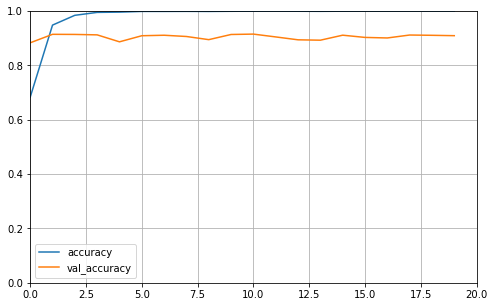

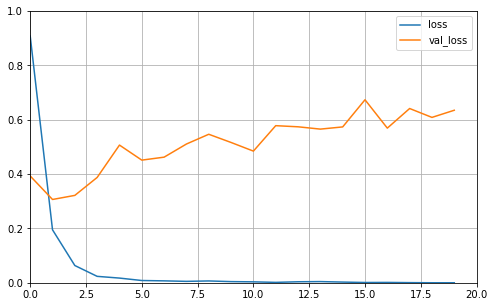

In [11]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = history.history['val_' + label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()


plot_learning_curves(history, 'accuracy', 20, 0, 1)
plot_learning_curves(history, 'loss', 20, 0, 1)



In [12]:
bi_lstm_model.evaluate(test_dataset)

157/157 [==============================] - 2s 14ms/step - loss: 0.6505 - accuracy: 0.9214


[0.6505163641421089, 0.9214]